In [1]:
import pandas as pd
# pd.set_option('display.max_rows', 100) #to unpack dataframes with more rows
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#This just shows number of completed walks by price for each owner (ONLY WALKS CONSIDERED)
df = pd.read_csv('owner_elasticity_11_04.csv').sort_values('OWNER_KEY').reset_index()
df = df.rename(columns = {'OWNER_KEY': 'Owner Key'})
df = df.drop('index', axis = 1)

#These both come from running elasticity loop at bottom. df_new shows all elasticities across completed walks
df_new = pd.read_csv('df_new_11_04_run')
df_mean = pd.read_csv('df_mean_11_04_run')

#Version 2.0 with S&B filter removed per Jessy request
df_filtered_owners = pd.read_csv('five_plus_walks_v2.csv').sort_values('OWNER_KEY').reset_index()
df_filtered_owners = df_filtered_owners.drop('index', axis = 1)
df_filtered_owners['is_in_filtering_logic'] = True
df_filtered_owners = df_filtered_owners.rename(columns = {'OWNER_KEY': 'Owner Key'})

#Target list I emailed Jessy November 4th evening (rewmoving luxury users since beyond scope of discounted trgting)
df_target_list = pd.read_csv('SB_Targeting_11_04_clean.csv').sort_values('Owner Key')
df_target_list = df_target_list[df_target_list['Category'] != 'Luxury users']

#List of average walk discount and % walks discounted by owner
df_discounts = pd.read_csv('discounts_by_owner.csv').sort_values('OWNER_KEY')
df_discounts = df_discounts.rename(columns = {'OWNER_KEY': 'Owner Key'})

#Combining the target list I prepared Jessy with list of average walk discount and % walks discounted by owner
df_discount_by_target_list = pd.merge(df_discounts, df_target_list, on = 'Owner Key')

#Preview one dataset
# df.head(10)

# Exploratory Data Analysis

We have been presented with the challenge of identifying various user segments for holiday S&B targeted promotions. Leveraging economic theory; specifically, elasticity, should allow us to solve this business problem.

For context, elasticity is the degree to which a demand or supply is sensitive to changes in transaction costs. You can learn more [here](https://www.youtube.com/watch?v=HHcblIxiAAk). Negative price elasticities indicate discount sensitivity (lower transaction costs translate to higher consumption), so we will be focusing on those users in this analysis and comms campaigns.

For users who have completed more than 1 walk since beginning of year 2018, let's see what their elasticity distribution looks like. From here, we'll cherry pick users who have noticeably low price elasticities of demand to confirm that our approach in fact seems appropriate here

### What is the price elasticity distribution for owners who have completed multiple walks since 2018?

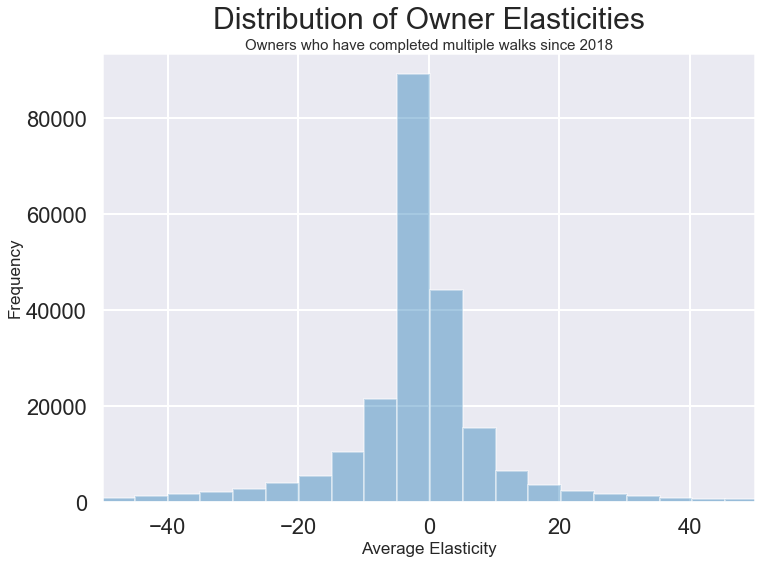

In [3]:
#Defining plotting object
sns.set_style('darkgrid')
sns.set_context('poster')
size = (11.7, 8.27)
fig, ax = plt.subplots(figsize=size)
ax.set_xlim(-50,50)


#Preparing graph
plt.ylabel('Frequency')
plt.title('')
ax.set_xlabel(ax.get_xlabel(), fontsize=17)
ax.set_ylabel(ax.get_ylabel(), fontsize=17)
ax.text(x=0.5, y=1.04, s='Distribution of Owner Elasticities', 
        fontsize=30, ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1, s='Owners who have completed multiple walks since 2018', 
        fontsize=15, alpha=10, ha='center', va='bottom', transform=ax.transAxes)
sns.distplot(df_mean['Average Elasticity'], kde = False, bins = 3000, ax = ax)

### What are the summary statistics for our users' average elasticities?

In [4]:
#Ingesting and formatting summary stats
summary_stats = pd.DataFrame(df_mean['Average Elasticity'].describe()).round(1)
summary_stats = summary_stats.rename(columns = {'Average Elasticity': 'Values'})
summary_stats = summary_stats.rename(index={'count': 'Total Users', 'mean': 'Mean',
                                            'std': 'Standard Deviation',
                                            '25%': '25th Percentile', '50%': 'Median', 
                                            '75%': '75th Percentile', 'min': 'Min',
                                            'max': 'Max'})
summary_stats.head(10)

,Values
Total Users,228343.0
Mean,-2.8
Standard Deviation,70.7
Min,-5998.0
25th Percentile,-5.0
Median,0.0
75th Percentile,2.3
Max,9072.8


Now that we have a stronger of the distribution of elasticities for our owners, let's take a look at a couple users with very negative elasticities to validate that their consumption patterns match with what economic theory would stipulate.

### How do elasticities translaste into individual user consumption behavior?

This user has an elasticity value of -88.73

In [5]:
#Investigating someone with super low negative price elasticity (-88.73, key = 100491)
df[df['Owner Key'] == 100491].head(20).sort_values('OWNER_PAYOUT')

,Owner Key,OWNER_PAYOUT,COMPLETED_WALKS
98,100491,14.0,4
97,100491,16.8,60
100,100491,18.2,2
96,100491,20.0,1
99,100491,24.0,17


This user has an elasticity value of -60.23

In [6]:
#Investigating someone with super low negative price elasticity (-60.23, key = 100455)
df[df['Owner Key'] == 100455].head(20).sort_values('OWNER_PAYOUT')

,Owner Key,OWNER_PAYOUT,COMPLETED_WALKS
71,100455,22.0,1
73,100455,25.0,17
72,100455,27.5,1
74,100455,30.0,1


This user has an elasticity value of -53.95

In [7]:
#Investigating someone with super low negative price elasticity (-53.95, key = 100443)
df[df['Owner Key'] == 100443].head(20).sort_values('OWNER_PAYOUT')

,Owner Key,OWNER_PAYOUT,COMPLETED_WALKS
57,100443,12.00,1
62,100443,18.00,9
64,100443,20.00,30
67,100443,22.00,96
55,100443,22.95,10
56,100443,24.00,4
66,100443,25.95,14
61,100443,27.00,57
68,100443,28.95,38
54,100443,30.00,35



As these tables show, users with very negative elasticities tend to consume more of our services as their transaction costs decline. Still, there are some very important caveats we need to note with this approach..

### What are some important caveats we should have in mind leveraging this framework?

- **Service type -** The current approach does not distinguish amongst different walk types (i.e. 20min vs 30min vs 60min walks). Given time constraints, this information has not been able to be incorporated in a meaningful way. I do not believe this should impact the current value of this work (it would only build off of what's been prepared thus far).

- **Geographic considerations -** A PP's location was not taken into consideration because of time constraints. Again, even without this information this would should still help with the current business problem.

- **Detailed breakout of transaction costs -** The detailed line-item cost breakout for each completed walk was not taken into consideration at this time. This work still has value without it, and we at least will be looking at the specific discounts below.

Now, let's see what the average discount and % discounted walks look like by user type..

### What does the average discount and % discounted walks look like by user type?

In [8]:
#Prepping Average Walk Discount Data
df_avg_walk_discount = pd.DataFrame(df_discount_by_target_list.groupby('Category')['AVERAGE_WALK_DISCOUNT'].describe()).round(2).reset_index()
df_avg_walk_discount = df_avg_walk_discount.rename(columns = {'count': 'Population Size', 'mean': 'Average Walk Discount'})
df_avg_walk_discount = df_avg_walk_discount.drop(['max', '75%', '50%', '25%', 'min', 'std'], axis = 1)

#Prepping Average Walk Discount Data
df_percent_discounted_walks = pd.DataFrame(df_discount_by_target_list.groupby('Category')['PERCENT_DISCOUNTED_WALKS'].describe()).round(2).reset_index()
df_percent_discounted_walks = df_percent_discounted_walks.rename(columns = {'mean': 'Average % Discounted Walks'})
df_percent_discounted_walks = df_percent_discounted_walks.drop(['max', '75%', '50%', '25%', 'min', 'std', 'count'], axis = 1)

#Combining the 2
df_avg_and_percent_discounted = pd.merge(df_avg_walk_discount, df_percent_discounted_walks, on = 'Category')
df_avg_and_percent_discounted = df_avg_and_percent_discounted.reindex([0,1,3,2])
df_avg_and_percent_discounted = df_avg_and_percent_discounted.reset_index()
df_avg_and_percent_discounted = df_avg_and_percent_discounted.drop('index', axis = 1)

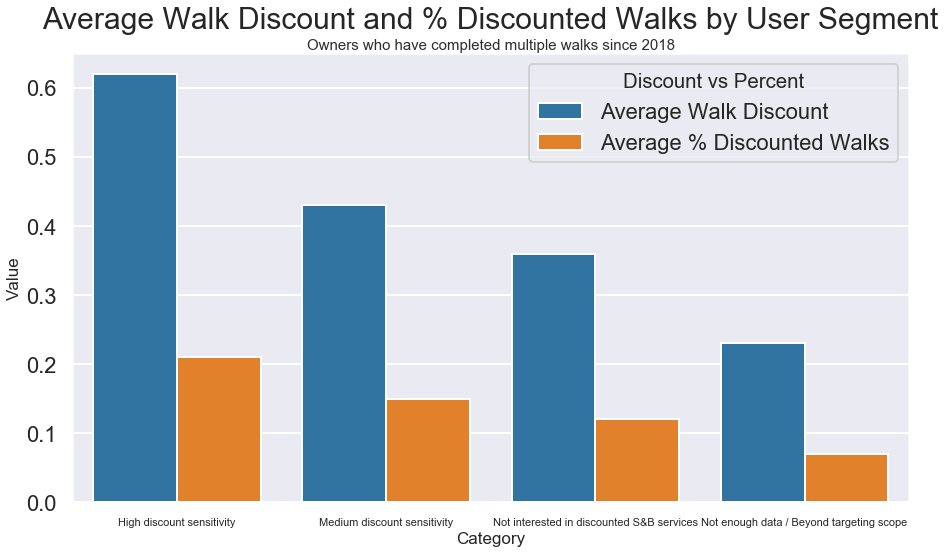

In [9]:
#Converting data to be graphed
df_final_graph = pd.melt(df_avg_and_percent_discounted, id_vars="Category", var_name="Discount vs Percent", value_name="Value")
df_final_graph = df_final_graph[(df_final_graph['Discount vs Percent'] != 'Population Size') &
                                (df_final_graph['Discount vs Percent'] != 'index')]
# df_final_graph = df_final_graph.reindex([4,5,7,6,8,9,11,10])
df_final_graph.head(20)

# #Creating graph
size = (15, 8.27)
fig, ax = plt.subplots(figsize=size)
ax.set_xlabel(ax.get_xlabel(), fontsize=17)
ax.set_ylabel(ax.get_ylabel(), fontsize=17)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.text(x=0.5, y=1.04, s='Average Walk Discount and % Discounted Walks by User Segment', 
        fontsize=30, ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1, s='Owners who have completed multiple walks since 2018', 
        fontsize=15, alpha=10, ha='center', va='bottom', transform=ax.transAxes)
sns.factorplot(x = 'Category', y= 'Value', data = df_final_graph,
               hue = 'Discount vs Percent', kind = 'bar', ax = ax)
plt.close(2)

In [10]:
#Changing format to % so its nicer to read
df_avg_and_percent_discounted['Average % Discounted Walks'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df_avg_and_percent_discounted['Average % Discounted Walks']], index = df_avg_and_percent_discounted.index)
df_avg_and_percent_discounted.head()

,Category,Population Size,Average Walk Discount,Average % Discounted Walks
0,High discount sensitivity,39426.0,0.62,21.00%
1,Medium discount sensitivity,21695.0,0.43,15.00%
2,Not interested in discounted S&B services,30131.0,0.36,12.00%
3,Not enough data / Beyond targeting scope,84787.0,0.23,7.00%


As you can see, the average discount per walk and % discounted walks decline based on the sensitivity levels noted in the _Category_ column. We can consider the `Not interested in discounted S&B services` cohort as low discount sensitivity users.

In [11]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>